In [1]:
!pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
from huggingface_hub import login

login()


In [7]:
!pip install bitsandbytes accelerate transformers --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np

# Load BRIGHTER dataset
dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")
label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']

# Load tokenizer
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

def preprocess(example):
    text = example["text"]
    if text is None or not isinstance(text, str) or text.strip() == "":
        text = "EMPTY"

    tokenized = tokenizer(text, truncation=True, padding="max_length", max_length=128)
    labels = [float(example[label]) for label in label_names]

    # Check for weird label values
    if any(l > 1 or l < 0 or np.isnan(l) for l in labels):
        labels = [0.0] * len(label_names)

    tokenized["labels"] = labels
    return tokenized

encoded_dataset = dataset.map(preprocess, batched=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/232 [00:00<?, ? examples/s]

In [2]:
import torch.nn as nn
from transformers import AutoModelForSequenceClassification

class DebugModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, **kwargs):
        outputs = self.model(**kwargs)
        logits = outputs.logits

        if torch.isnan(logits).any():
            print("NaNs in logits detected!")
            print(logits)
            logits = torch.nan_to_num(logits, nan=0.0, posinf=1e4, neginf=-1e4)

        logits = torch.clamp(logits, min=-30.0, max=30.0)
        return torch.nn.utils.rnn.pack_padded_sequence(logits, [logits.size(1)], batch_first=True, enforce_sorted=False)


In [3]:
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False
)



In [4]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False
)

#  Load model with quantization
model = AutoModelForSequenceClassification.from_pretrained(
    "meta-llama/Llama-3.2-1B",
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    num_labels=5,
)

# Set the pad_token_id in the model's config to match the tokenizer
model.config.pad_token_id = tokenizer.pad_token_id

model.gradient_checkpointing_enable()

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
import torch.nn.functional as F

def custom_loss_fn(outputs, labels):
    logits = outputs
    logits = torch.clamp(logits, min=-30.0, max=30.0)
    loss = F.binary_cross_entropy_with_logits(logits, labels.float(), reduction='mean')

    if torch.isnan(loss):
        print("NaN in loss!")
        print("Logits:", logits)
        print("Labels:", labels)
        loss = torch.tensor(0.0, requires_grad=True).to(logits.device)
    return loss


In [6]:
split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_data = split["train"]
eval_data = split["test"]


In [7]:
from transformers import Trainer, TrainingArguments
class DebugTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits


        if torch.isnan(logits).any():
            print(" NaNs in logits!")
            print(logits)

        loss = custom_loss_fn(logits, labels.float())

        if torch.isnan(loss):
            print(" NaN loss!")
            print("Logits:", logits)
            print("Labels:", labels)

        return (loss, outputs) if return_outputs else loss




In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Define the compute_metrics function
def compute_metrics(eval_pred):

    predictions = eval_pred.predictions
    labels = eval_pred.label_ids


    probs = 1 / (1 + np.exp(-predictions))  # Sigmoid
    binary_preds = (probs > 0.5).astype(int)

    # Calculate macro and micro F1, precision, and recall
    f1_macro = f1_score(labels, binary_preds, average="macro", zero_division=0)
    f1_micro = f1_score(labels, binary_preds, average="micro", zero_division=0)


    return {
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
    }

In [9]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    #logging_steps=10,
    save_strategy="no",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    max_grad_norm=1.0,
    bf16=True,
    report_to="none",
)


In [10]:
trainer = DebugTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

trainer.train()


<ipython-input-10-54e5f22e25fa>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DebugTrainer.__init__`. Use `processing_class` instead.
  trainer = DebugTrainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two varia

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,0.520000,0.386545,0.572621,0.707814
2,0.329100,0.326953,0.721449,0.760348
3,0.272000,0.329773,0.702884,0.753365
4,0.236400,0.318684,0.743955,0.774898
5,0.208000,0.334813,0.737753,0.772848
6,0.181200,0.346260,0.733399,0.765719
7,0.158200,0.362779,0.742003,0.773459
8,0.138700,0.371420,0.739607,0.770979
9,0.125100,0.385067,0.738559,0.771864
10,0.116500,0.387203,0.741142,0.772319


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to 

TrainOutput(global_step=3460, training_loss=0.22851328877355323, metrics={'train_runtime': 5362.6095, 'train_samples_per_second': 5.162, 'train_steps_per_second': 0.645, 'total_flos': 2.07059203129344e+16, 'train_loss': 0.22851328877355323, 'epoch': 10.0})

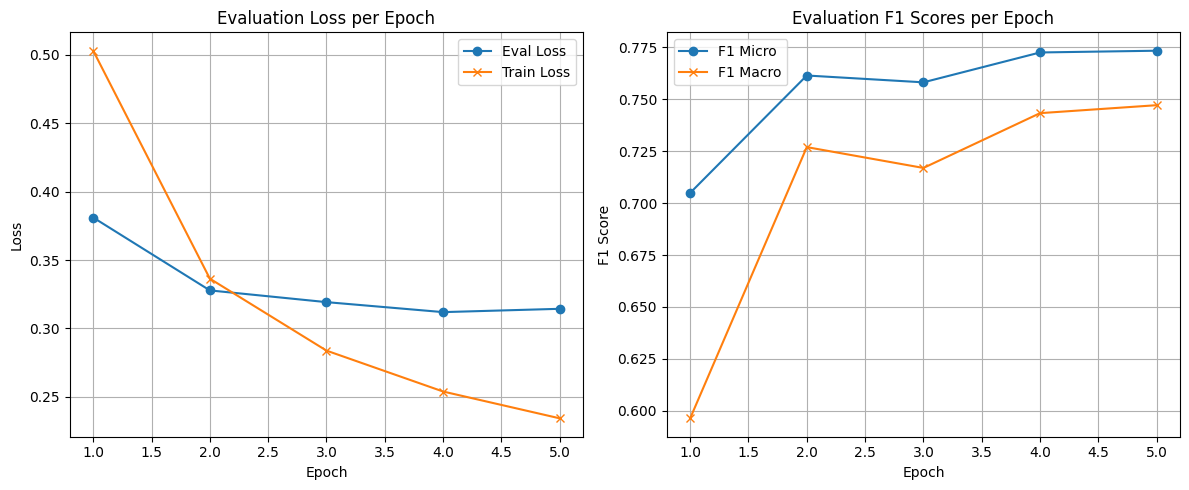

In [ ]:
import matplotlib.pyplot as plt

# Extract log history (includes training and eval logs)
log_history = trainer.state.log_history

# Separate values
train_epochs = []
train_loss = []
eval_epochs = []
eval_loss = []
eval_f1_micro = []
eval_f1_macro = []

for log in log_history:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_epochs.append(log["epoch"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_epochs.append(log["epoch"])
        eval_loss.append(log["eval_loss"])
        eval_f1_micro.append(log["eval_f1_micro"])
        eval_f1_macro.append(log["eval_f1_macro"])

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(eval_epochs, eval_loss, marker='o', label="Eval Loss")
plt.plot(train_epochs, train_loss, marker='x', label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evaluation Loss per Epoch")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_f1_micro, marker='o', label="F1 Micro")
plt.plot(eval_epochs, eval_f1_macro, marker='x', label="F1 Macro")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Evaluation F1 Scores per Epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from datasets import load_dataset
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Load BRIGHTER dev set
dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")
dev_dataset = dataset["test"] # This is the test dataset

# Define label names
label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
tokenizer.pad_token = tokenizer.eos_token

# Define the same preprocessing function used for training
def preprocess(example):
    tokenized = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    tokenized["labels"] = [float(example[label]) for label in label_names]
    return tokenized

# Preprocess the dev set
encoded_test = dev_dataset.map(preprocess, batched=False) # Use dev_dataset here

# Evaluate using Trainer
metrics = trainer.evaluate(encoded_test)
print("Validation Metrics:", metrics)

# Predict raw logits using Trainer
raw_preds = trainer.predict(encoded_test)

# Convert logits to probabilities
probs = torch.sigmoid(torch.tensor(raw_preds.predictions)).numpy()

# Apply threshold (0.5) to get binary labels
binary_preds = (probs > 0.5).astype(int)

# Prepare submission file
submission_df = pd.DataFrame(binary_preds, columns=label_names)
submission_df.insert(0, "id", dev_dataset["id"]) # Use dev_dataset here as well

# Save to CSV
submission_df.to_csv("submission_test.csv", index=False)
print("Submission saved to submission_test.csv")

/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Validation Metrics: {'eval_loss': 0.3143593668937683, 'eval_f1_macro': 0.7470778617182618, 'eval_f1_micro': 0.773284760170006, 'eval_runtime': 162.4123, 'eval_samples_per_second': 34.074, 'eval_steps_per_second': 4.261, 'epoch': 5.0}


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Submission saved to submission_test.csv


In [ ]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Load submission file
submission_df = pd.read_csv("submission_test.csv")  # Adjust path if needed

# 2. Load gold labels from 'dev' set
dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")
gold_df = pd.DataFrame(dataset["test"])

# 3. Align dataframes by 'id'
label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']
submission_df = submission_df.set_index("id").sort_index()
gold_df = gold_df.set_index("id").sort_index()
submission_df = submission_df.loc[gold_df.index]
gold_labels = gold_df[label_names].astype(int)

# 4. Calculate metrics
binary_preds = submission_df[label_names].values
true_labels = gold_labels.values

# Macro
precision_macro = precision_score(true_labels, binary_preds, average="macro", zero_division=0)
recall_macro = recall_score(true_labels, binary_preds, average="macro", zero_division=0)
f1_macro = f1_score(true_labels, binary_preds, average="macro", zero_division=0)

# Micro
precision_micro = precision_score(true_labels, binary_preds, average="micro", zero_division=0)
recall_micro = recall_score(true_labels, binary_preds, average="micro", zero_division=0)
f1_micro = f1_score(true_labels, binary_preds, average="micro", zero_division=0)

# 5. Print report
print("Evaluation Metrics Breakdown")
print(" Macro Average:")
print(f"   Precision: {precision_macro:.4f}")
print(f"   Recall:    {recall_macro:.4f}")
print(f"   F1 Score:  {f1_macro:.4f}")
print("\n Micro Average:")
print(f"   Precision: {precision_micro:.4f}")
print(f"   Recall:    {recall_micro:.4f}")
print(f"   F1 Score:  {f1_micro:.4f}")

Evaluation Metrics Breakdown
 Macro Average:
   Precision: 0.7785
   Recall:    0.7208
   F1 Score:  0.7471

 Micro Average:
   Precision: 0.7922
   Recall:    0.7552
   F1 Score:  0.7733
